In [37]:
!pip install skan

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from skimage import img_as_ubyte, measure, morphology, feature, color
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skan import Skeleton, summarize


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_im = '/content/drive/MyDrive/EIM/Retina/RETINA/Original'
path_man = '/content/drive/MyDrive/EIM/Retina/RETINA/Ground truth'


In [23]:
def calcola_vasi_per_tipo(img):

  if np.max(img) == 0:
    print('immagine vuota')
    return 0, 0
  skt = skeletonize(img)

  skeleton_data = Skeleton(skt)
  skel_summary = summarize(skeleton_data)

  # count how many branches have branch-type = 1 and 2
  N_J2E = len(skel_summary[skel_summary['branch-type'] == 1])
  N_J2J = len(skel_summary[skel_summary['branch-type'] == 2])

  return N_J2E, N_J2J

def calculate_glcm_features(gray_image):
    # Specify the distances and angles for GLCM
    distances = [3, 7, 11]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Calculate GLCM
    glcm = greycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Calculate GLCM features
    contrast = np.mean(greycoprops(glcm, 'contrast'))
    dissimilarity = np.mean(greycoprops(glcm, 'dissimilarity'))
    homogeneity = np.mean(greycoprops(glcm, 'homogeneity'))
    energy = np.mean(greycoprops(glcm, 'energy'))
    correlation = np.mean(greycoprops(glcm, 'correlation'))

    return contrast, dissimilarity, homogeneity, energy, correlation



In [24]:
list_im = os.listdir(path_im)
list_man = os.listdir(path_man)

DOI_man = []
n_e_list = []
n_j_list = []

for file_im in tqdm(list_man):
  image_path_m = os.path.join(path_man,file_im)
  img = Image.open(image_path_m)
  pic = np.array(img)
  DOI_man.append(np.sum(pic))
  n_e, n_j = calcola_vasi_per_tipo(pic)
  n_e_list.append(n_e)
  n_j_list.append(n_j)


DOI_man = DOI_man -np.min(DOI_man)/(np.max(DOI_man)-np.min(DOI_man))
n_e_list = n_e_list -np.min(n_e_list)/(np.max(n_e_list)-np.min(n_e_list))
n_j_list = n_j_list -np.min(n_j_list)/(np.max(n_j_list)-np.min(n_j_list))




 51%|█████     | 307/600 [19:25<11:27,  2.35s/it]

immagine vuota


 57%|█████▋    | 343/600 [20:52<10:38,  2.48s/it]

immagine vuota


100%|██████████| 600/600 [39:58<00:00,  4.00s/it]


ValueError: ignored

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-28-e0b22fd614af>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], cmap='viridis', edgecolor='k', s=50)


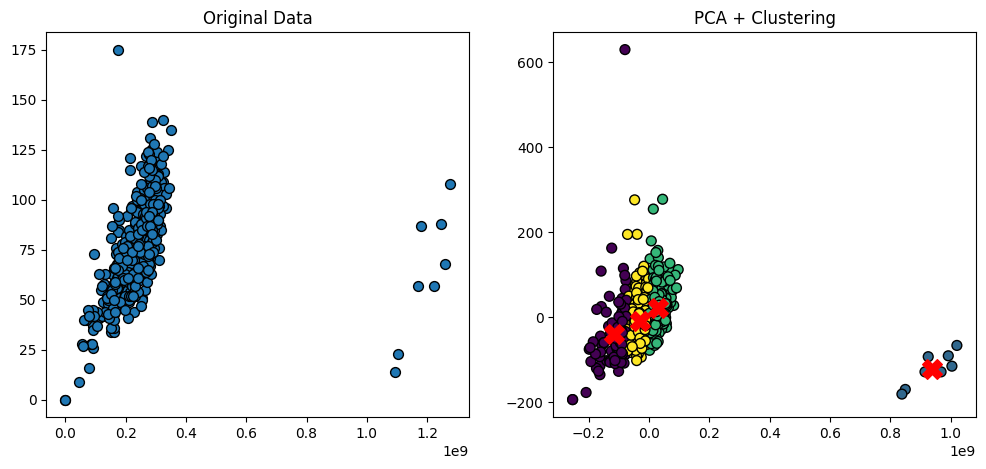

In [28]:
pca = PCA(n_components=2)

# Convert lists to NumPy arrays and stack them vertically
X = np.vstack((DOI_man, n_e_list, n_j_list)).T  # Transpose to make it a 2D array

X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

# Visualize the original data and the obtained clusters
plt.figure(figsize=(12, 5))

# Plot original data
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], cmap='viridis', edgecolor='k', s=50)
plt.title('Original Data')

# Plot data transformed with PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('PCA + Clustering')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

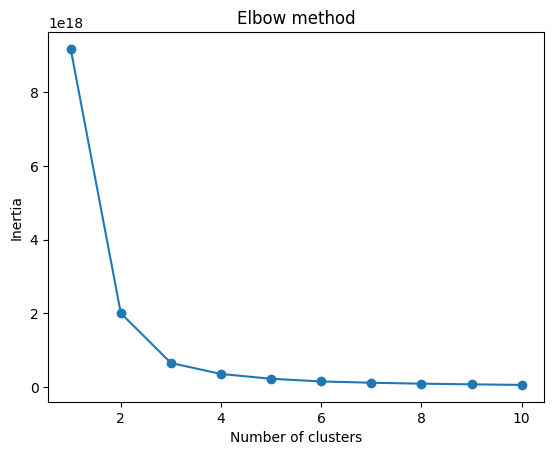

In [29]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state = 0 )
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-31-4cb94c61b8a5>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:,0], X[:,1], cmap='viridis', edgecolor='k', s=50)


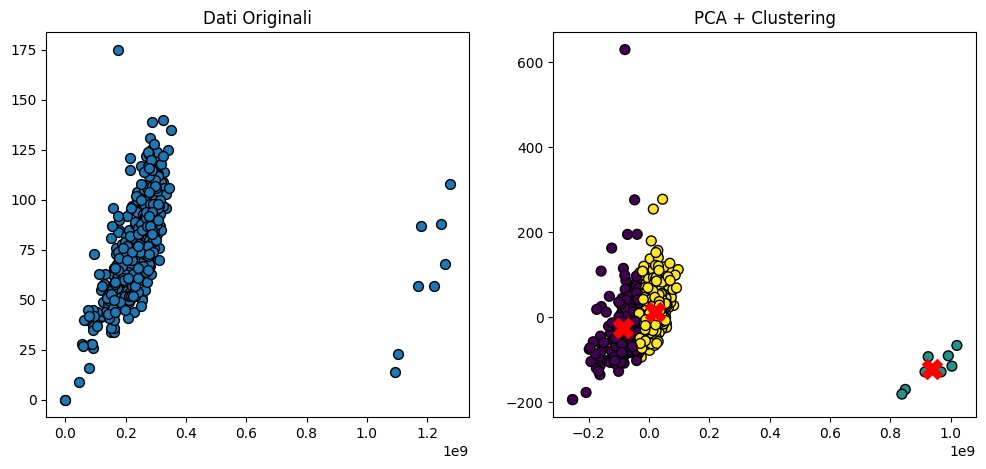

In [31]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

# Visualizza i dati originali e i cluster ottenuti
plt.figure(figsize=(12, 5))

# Plot dati originali
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], X[:,1], cmap='viridis', edgecolor='k', s=50)
plt.title('Dati Originali')

# Plot dati trasformati con PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroidi')
plt.title('PCA + Clustering')
plt.legend

plt.show()

In [33]:
dati = {'Immagine': list_im, 'DOI': DOI_man, 'n_e':n_e_list, 'n_j':n_j_list, 'cluster' : y_kmeans  }
df = pd.DataFrame(dati)

In [36]:
for i in range(3):
  print(f'cluster {i}')
  print(len(df[df['cluster'] == i]))

cluster 0
177
cluster 1
8
cluster 2
415


In [38]:
# Seleziona solo le righe in cui 'cluster' è 0 o 2
df_selected = df[df['cluster'].isin([0, 2])]

# Calcola l'85% delle righe selezionate
percentile_85 = int(0.85 * len(df_selected))

# Estrai casualmente l'85% delle righe
selected_indices = random.sample(df_selected.index.tolist(), percentile_85)

# Crea la colonna 'set' e assegna 'construction' alle righe selezionate, 'test' alle altre
df['set'] = 'test'
df.loc[selected_indices, 'set'] = 'construction'

In [39]:
percorso_file_csv = '/content/drive/MyDrive/EIM/Retina/RETINA/data_set.csv'

df.to_csv(percorso_file_csv, index=False)